# Classifying Pictures of Cats and Dogs

## Description of dataset

Given a set of labeled images of  cats and dogs, we'll be generating a  machine learning model that will be trained on images of cats and dogs and will be then used to classify a set of new images as either a cats or dog. (1 = dog, 0 for cat). 

The dataset is comprised of 25000 images of both cats and dogs, and a test dataset of 12500 images.

A few sample labeled images from the training dataset are shown below.

![alt](https://cdn-images-1.medium.com/max/1600/1*sIlE__p4OtMqF30lP7dtwQ.png)

# Approach

Each picture is represented as a 3D array. To simplify things, we need to do two things:

![RGB Doge](https://cdn-images-1.medium.com/max/1600/1*9ng9AxixrDUGvVfKA7dypg.png)

1. Resize all the training data to 50x50 pixels. An example of a 64x64 image is shown above.

2. Convert all the pictures to greyscale. This gives us several advantages: 

> *Converting to gray scale is not necessary for image processing, but is usually done for a few reasons:*
>
> **Simplicity** - Many image processing operations work on a plane of image data (e.g., a single color channel) at a time. So if you have an RGBA image you might need to apply the operation on each of the four image planes and then combine the results. Gray scale images only contain one image plane (containing the gray scale intensity values).
>
>**Data reduction** - Suppose you have a RGBA image (red-green-blue-alpha). If you converted this image to gray scale you would only need to process 1/4 of the data compared to the color image. For many image processing applications, especially video processing (e.g., real-time object tracking), this data reduction allows the algorithm to run in a reasonable amount of time.
>
>However, it's important to understand that while there are many advantages of converting to gray scale, it is not always desirable. When you convert to gray scale you not only reduce the quantity of image data, but you also lose information (e.g., color information). For many image processing applications color is very important, and converting to gray scale can worsen results.
>
**To summarize**: If converting to gray scale still yields reasonable results for whatever application you're working on, it is probably desirable, especially due to the likely reduction in processing time. However it comes at the cost of throwing away data (color data) that may be very helpful or required for many image processing applications.

See: https://stackoverflow.com/questions/20473352/is-conversion-to-gray-scale-a-necessary-step-in-image-preprocessing

In [1]:
# Setting up
import numpy as np
import os
import PIL  # replaces cv2
from skimage import io
from skimage import transform
from random import shuffle
from tqdm import tqdm
import tensorflow as tf

import matplotlib.pyplot as plt


import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression


ROOT_DATA_DIR = '/scratch/MLC-Neural-Networks-I'
TRAIN_DIR = os.path.join(ROOT_DATA_DIR, 'train')
TEST_DIR = os.path.join(ROOT_DATA_DIR, 'test')
IMG_SIZE = 50
LR = 1e-3
MODEL_NAME = 'dogs-vs-cats-convnet'

/scratch/mlc/root/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Let's create a function that encodes the labels of the training images
def create_label(image_name):
    """ Create an one-hot encoded vector from image name """
    word_label = image_name.split('.')[-3]
    if word_label == 'cat':
        return np.array([1,0])
    elif word_label == 'dog':
        return np.array([0,1])
    

# And, since we want to resize each image to 50 x 50 pixels
# and convert to greyscale
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        path = os.path.join(TRAIN_DIR, img)
        img_data = io.imread(path, as_grey=True)  # to greyscale
        img_data = transform.resize(img_data, (IMG_SIZE, IMG_SIZE))  # resize
        training_data.append([np.array(img_data), create_label(img)])  # collect
    shuffle(training_data)  # randomize
    np.save('train_data.npy', training_data)  # save
    return training_data

In [3]:
# Similarly for the test data:
def create_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img_data = io.imread(path, as_grey=True)  # greyscale
        img_data = transform.resize(img_data, (IMG_SIZE, IMG_SIZE))  # resize
        testing_data.append([np.array(img_data), img_num])  # collect

    shuffle(testing_data)  # randomize
    np.save('test_data.npy', testing_data)  # save
    return testing_data

In [4]:
# read, resize, and convert to greyscale all the images (if necessary)

# first, a convenience function to check for file existence:
def file_exists(filepath):
    if os.path.isfile(filepath) and os.path.exists(filepath):
        return True
    return False


# now load, or generate in the current directory
if file_exists('train_data.npy'):
    train_data = np.load('train_data.npy')
else:
    # If dataset is not created:
    train_data = create_train_data()


# similar to the above
if file_exists('test_data.npy'):
    test_data = np.load('test_data.npy')
else:
    # If dataset is not created:
    test_data = create_test_data()

Now, let’s split the data. 24,500 images for training and 500 for testing. We also need to reshape the data appropriately for TensorFlow:

In [5]:
train = train_data[:-500]  # skip the last 500
test = train_data[-500:]  # use the last 500 for training

# -1 means that 'the new shape should be compatible with the original shape'
# See: https://stackoverflow.com/a/42510505/866930
# This means to reshape into 50x50 pixel arrays, which have 1 dimension
# That dimension is greyscale which goes from 0 to 255
X_train = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = [i[1] for i in train]

X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = [i[1] for i in test]

# Convolutional Neural Networks

A convolutional neural network consists of several layers. 

![CNN](http://white.stanford.edu/teach/images/d/df/Mylenet.png)

These layers can be of three types:

1. **Convolutional**: Convolutional layers consist of a rectangular grid of neurons. It requires that the previous layer also be a rectangular grid of neurons. Each neuron takes inputs from a rectangular section of the previous layer; the weights for this rectangular section are the same for each neuron in the convolutional layer. Thus, the convolutional layer is just an image convolution of the previous layer, where the weights specify the convolution filter. In addition, there may be several grids in each convolutional layer; each grid takes inputs from all the grids in the previous layer, using potentially different filters.

2. **Max-Pooling**: After each convolutional layer, there may be a pooling layer. The pooling layer takes small rectangular blocks from the convolutional layer and subsamples it to produce a single output from that block. There are several ways to do this pooling, such as taking the average or the maximum, or a learned linear combination of the neurons in the block. Our pooling layers will always be max-pooling layers; that is, they take the maximum of the block they are pooling.

3. **Fully-Connected**: Finally, after several convolutional and max pooling layers, the high-level reasoning in the neural network is done via fully connected layers. A fully connected layer takes all neurons in the previous layer (be it fully connected, pooling, or convolutional) and connects it to every single neuron it has. Fully connected layers are not spatially located anymore (you can visualize them as one-dimensional), so there can be no convolutional layers after a fully connected layer.

Note that we are not really constrained to two-dimensional convolutional neural networks. We can in the exact same way build one- or three- dimensional convolutional neural networks; our filters will just become appropriately dimensioned, and our pooling layers will change dimension as well. We may, for instance, want to use one-dimensional convolutional nets on audio or three-dimensional nets on MRI data.


### Reference:
1. http://andrew.gibiansky.com/blog/machine-learning/convolutional-neural-networks/

Now we build our Convolutional Network which can be thought of small sliding lenses (e.g. 10 x 10) which are "activated" when placed above some feature that is "familiar" to them. Since we're trying to distinguish between cats and dogs, this requires more features and hences involves looking at portions of the image rather than pixels alone. Hence, a convolutional network can examine and learn from larger portions of an image rather than single pixels.

So, in our case we'll be using `tflearn` to build the Convolutional Neural Network (CNN). In addition to hidden layers, we'll also add a dropout layer.

In [6]:
tf.reset_default_graph()

# create an initial input layer bases on the shape of the resized images
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

# now add the input layer to a convolutional layer with 32 filters
# and a stride of 5 using an ReLU activation
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5) # create a pool of 5 kernels

# similar to above, but with more filters
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# now add a fully connected layer
convnet = fully_connected(convnet, 1024, activation='relu')

# now add a dropout layer
# As other regularization techniques the use of dropout also make the training 
# loss error a little worse. But that's the idea, basically we want to trade 
# training performance for more generalization. Remember that's more capacity 
# you add on your model (More layers, or more neurons) more prone to over-fit 
# it becomes.
#
# adding dropout after the max-pooling layers, creates image noise augmentation
# which gives the NN more generality
convnet = dropout(convnet, 0.8)

# add another fully connected layer of 2 neurons - these will be our
# outputs which will hold the probabilities of an image being a cat or dog.
convnet = fully_connected(convnet, 2, activation='softmax')

# We use Adam as optimizer with learning rate set to 0.001. 
# Our loss function is categorical cross entropy. Finally, we train our 
# Deep Neural Net for 10 epochs.
convnet = regression(convnet, 
                     optimizer='adam', 
                     learning_rate=LR, 
                     loss='categorical_crossentropy', 
                     name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose=0)
model.fit({'input': X_train}, {'targets': y_train}, n_epoch=10, 
          validation_set=({'input': X_test}, {'targets': y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.30335 | time: 5.135s
| Adam | epoch: 010 | loss: 0.30335 - acc: 0.8761 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.29966 | time: 6.149s
| Adam | epoch: 010 | loss: 0.29966 - acc: 0.8791 | val_loss: 0.56914 - val_acc: 0.7700 -- iter: 24500/24500
--


# Building a bigger model (more layers)

In [7]:
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')

convnet = regression(convnet, 
                     optimizer='adam', 
                     learning_rate=LR, 
                     loss='categorical_crossentropy', 
                     name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose=0)
model.fit({'input': X_train}, {'targets': y_train}, n_epoch=10, 
          validation_set=({'input': X_test}, {'targets': y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.27014 | time: 6.742s
| Adam | epoch: 010 | loss: 0.27014 - acc: 0.8859 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.26853 | time: 7.760s
| Adam | epoch: 010 | loss: 0.26853 - acc: 0.8848 | val_loss: 0.60048 - val_acc: 0.7780 -- iter: 24500/24500
--


Using the same model, but by adding more layers we've improved the performance. Our model has much more parameters and can learn more complex functions. One proof of that is the validation accuracy that is around 0.8. Let’s take our model for a spin!

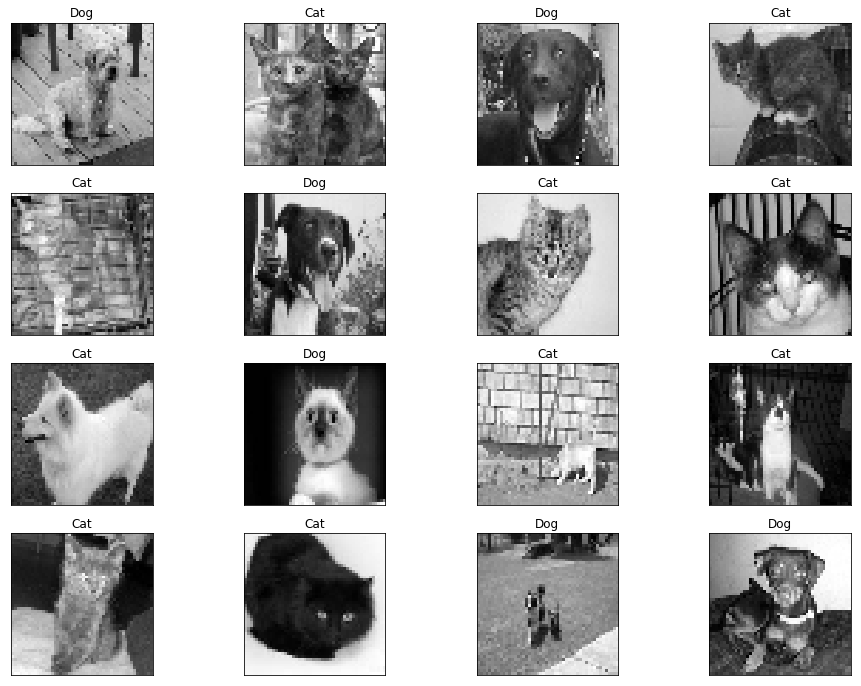

In [8]:
# look at some of the test data images:
fig=plt.figure(figsize=(16, 12))

for num, data in enumerate(test_data[:16]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='Dog'
    else:
        str_label='Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

# Activity 1: Modify the number of layers in your CNN - how does it affect the result?

# Activity 2: How does the activation function affect the performance of the CNN?

Hint: Keras supports the following activation functions: `softplus`, `softsign`, `softsign`, `relu`, `tanh`, `sigmoid`, `hard_sigmoid`, and `linear`. See: https://keras.io/activations/

# Reference
1. https://medium.com/@curiousily/tensorflow-for-hackers-part-iii-convolutional-neural-networks-c077618e590b
2. https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/dropout_layer.html
3. https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/
4. https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f
5. https://www.datasciencecentral.com/profiles/blogs/dogs-vs-cats-image-classification-with-deep-learning-using
    